In [1]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('seaborn-darkgrid')


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:

data_2 = pd.read_csv('../output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns')
data_2 = data_2.iloc[:, :-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])

date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()


,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,1970-01-01 00:00:01.641598546,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


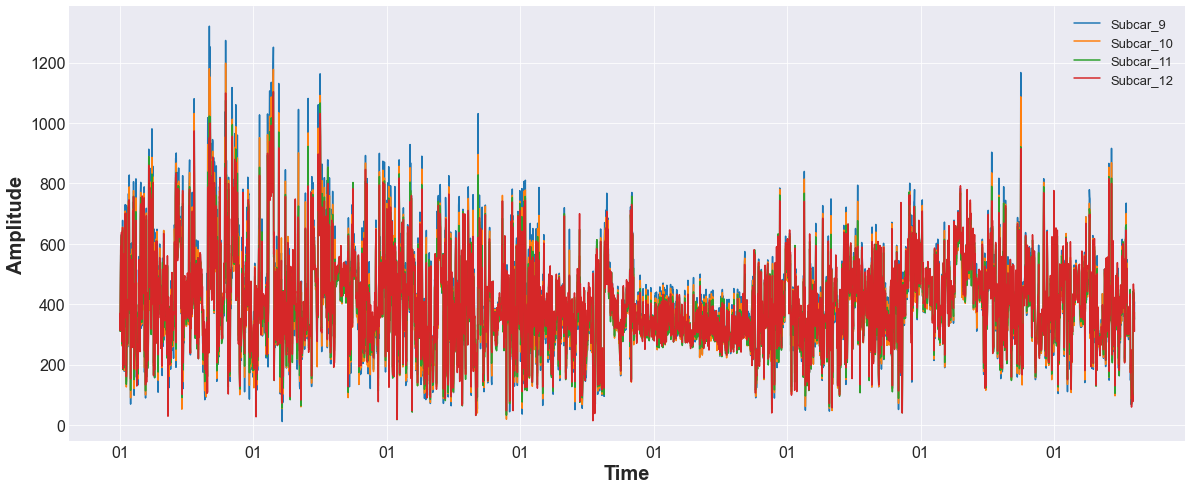

In [3]:
plot_cols = ['Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12']
plot_features = data_2[plot_cols ]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=13)
# plt.savefig('../images/raw_minMax.png', dpi=500)


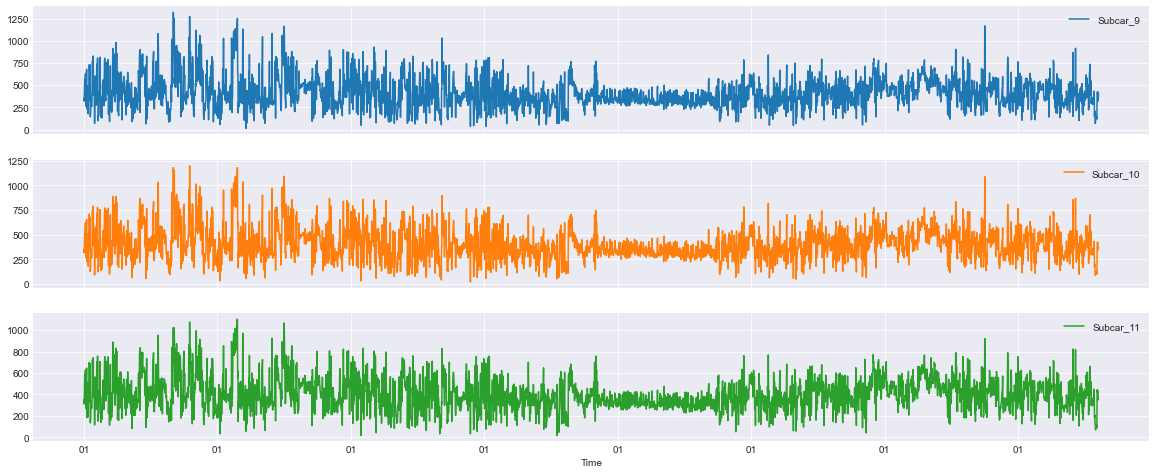

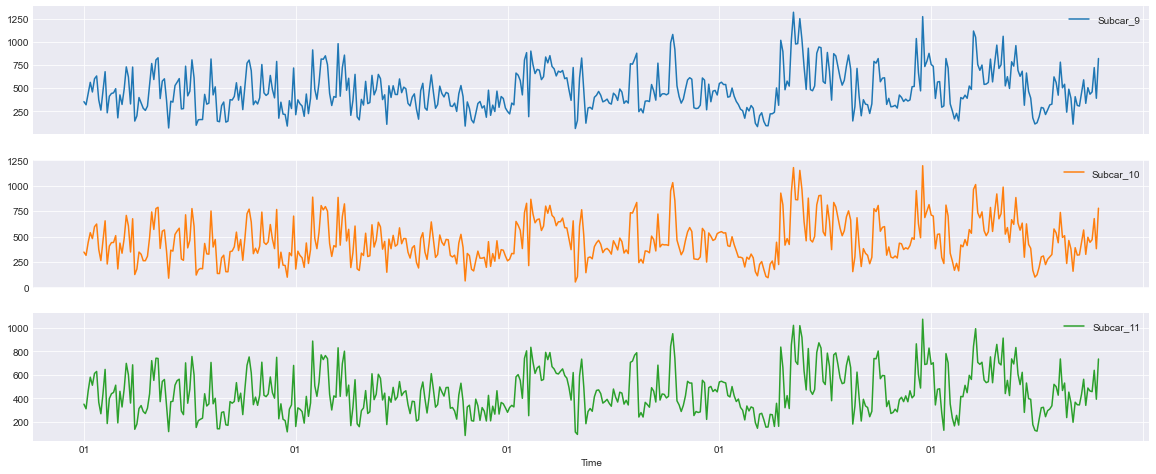

In [4]:
plot_cols = ['Subcar_9', 'Subcar_10', 'Subcar_11' ]
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_minMax_1.pdf', dpi=500)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_minMax_2.pdf', dpi=500)


In [5]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())


          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158795  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360387   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [6]:
df_input = data_2[['Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12', ]]
df_input.head()


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
Time,,,,
1970-01-01 00:00:01.641598542,353.793725,347.315419,349.905702,369.545667
1970-01-01 00:00:01.641598543,319.820262,315.317300,310.386855,313.359219
1970-01-01 00:00:01.641598544,441.279957,441.367194,461.677376,465.649009
1970-01-01 00:00:01.641598545,562.694411,538.674299,580.400724,591.622346
1970-01-01 00:00:01.641598546,458.423385,479.883319,511.391240,527.319637


In [7]:
df_input.describe()


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
count,3802.000000,3802.000000,3802.000000,3802.000000
mean,410.627681,403.013887,401.351757,409.075167
std,171.775869,160.406865,152.042491,149.184960
min,11.661904,19.235384,17.029386,14.317821
25%,301.906856,299.537560,302.426850,310.169711
50%,387.431284,381.450521,381.629371,392.020408
75%,496.494461,487.182967,486.122154,497.416318
max,1320.984860,1198.269586,1101.918781,1104.339169


In [8]:
df_input.query("Subcar_9 > 500")


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
Time,,,,
1970-01-01 00:00:01.641598545,562.694411,538.674299,580.400724,591.622346
1970-01-01 00:00:01.641598547,601.239553,597.501464,612.315278,607.217424
1970-01-01 00:00:01.641598547,631.708794,623.773196,629.221742,638.401128
1970-01-01 00:00:01.641598550,677.784627,655.331977,646.693900,654.083328
1970-01-01 00:00:01.641598556,730.010959,708.801806,698.401747,700.925103
...,...,...,...,...
1970-01-01 00:00:01.641600103,656.966514,620.133050,616.235345,615.601332
1970-01-01 00:00:01.641600104,533.258849,523.495941,529.429882,522.215473
1970-01-01 00:00:01.641600105,734.908158,700.594034,663.127439,645.600496


In [9]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled


array([[0.26130438, 0.27826168, 0.30682973, 0.32589072],
       [0.23535703, 0.25112242, 0.27040311, 0.27434453],
       [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
       ...,
       [0.31431976, 0.33538326, 0.37370201, 0.39796507],
       [0.23619976, 0.27684802, 0.32360963, 0.35399159],
       [0.30271959, 0.30005974, 0.3069601 , 0.2715127 ]])

In [10]:
# features are inputs as well as ta
# target value is index 2

features = data_scaled
target = data_scaled[:, 0]


In [11]:
TimeseriesGenerator(features, target, length=6,
                    sampling_rate=1, batch_size=1)[0]


(array([[[0.26130438, 0.27826168, 0.30682973, 0.32589072],
         [0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         [0.34121565, 0.39069938, 0.4556795 , 0.47063465],
         [0.450292  , 0.49045743, 0.54870653, 0.54393394]]]),
 array([0.47356299]))

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=120, shuffle=False) # false for timeseries
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)


X_train.shape:  (3041, 4)
X_test.shape:  (761, 4)


In [13]:
win_length = 144  # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 4
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [14]:
train_generator[0]


(array([[[0.26130438, 0.27826168, 0.30682973, 0.32589072],
         [0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         ...,
         [0.27835589, 0.30253303, 0.3397856 , 0.35555178],
         [0.31792614, 0.36768943, 0.39365483, 0.4225886 ],
         [0.07417749, 0.10961531, 0.14609373, 0.20045649]],
 
        [[0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         ...,
         [0.31792614, 0.36768943, 0.39365483, 0.4225886 ],
         [0.07417749, 0.10961531, 0.14609373, 0.20045649],
         [0.3926685 , 0.38698947, 0.36624711, 0.3495528 ]],
 
        [[0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         [0.34121565, 0.39069938, 0.4556795 , 0.47063465],
         ...,
         [0.07417749, 0.10961531, 0.14609373, 0.20045649],
        

In [15]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(
        win_length, num_features), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 144, 128)          68096     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 144, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 144, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [16]:
cp1 = ModelCheckpoint('../save/lstm_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}

In [17]:
history = lstm_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp1 ])


Epoch 1/20
91/91 [==============================] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.1046WARNING:tensorflow:From C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../save/lstm_model\assets
91/91 [==============================] - 25s 270ms/step - loss: 0.0203 - mean_absolute_error: 0.1046 - val_loss: 0.0118 - val_mean_absolute_error: 0.0842
Epoch 2/20
91/91 [==============================] - 24s 261ms/step - loss: 0.0169 - mean_absolute_error: 0.0962 - val_loss: 0.0117 - val_mean_absolute_error: 0.0840
Epoch 3/20
91/91 [===

In [18]:
lstm_eval = lstm_model.evaluate(
    test_generator, verbose=0
)
lstm_eval
val_performance['LSTM'] = lstm_model.evaluate(train_generator)
performance['LSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 5s 60ms/step - loss: 0.0155 - mean_absolute_error: 0.0959


In [19]:
predictions_lstm = lstm_model.predict(test_generator)


In [20]:
from tensorflow.keras.models import load_model
lstm_model = load_model('../save/lstm_model/')

In [21]:
predictions_lstm.shape[0]


617

In [22]:
predictions_lstm


array([[0.3740592 ],
       [0.3779718 ],
       [0.3896404 ],
       [0.40234584],
       [0.41426408],
       [0.41584414],
       [0.40813476],
       [0.398599  ],
       [0.3940548 ],
       [0.39313704],
       [0.390826  ],
       [0.39051154],
       [0.393285  ],
       [0.39066887],
       [0.38042477],
       [0.36855438],
       [0.35997093],
       [0.3594768 ],
       [0.36588296],
       [0.3702377 ],
       [0.37395376],
       [0.37374288],
       [0.36988312],
       [0.36173522],
       [0.353154  ],
       [0.3492367 ],
       [0.34321308],
       [0.33768922],
       [0.33381802],
       [0.33339936],
       [0.33535826],
       [0.33857912],
       [0.342089  ],
       [0.34645057],
       [0.35106376],
       [0.35581774],
       [0.35615218],
       [0.3529818 ],
       [0.3511855 ],
       [0.3487255 ],
       [0.34703112],
       [0.34742668],
       [0.34932798],
       [0.3502312 ],
       [0.3513354 ],
       [0.34888434],
       [0.35042125],
       [0.358

In [23]:
y_test


array([0.29244596, 0.35198348, 0.36175921, 0.26042866, 0.26189846,
       0.26844404, 0.2585389 , 0.26306772, 0.26910365, 0.15445075,
       0.20390649, 0.40778704, 0.2098589 , 0.24497661, 0.37471418,
       0.38316737, 0.30191834, 0.41769515, 0.45070593, 0.30268402,
       0.29910845, 0.3127504 , 0.30809781, 0.46128071, 0.36794034,
       0.24092465, 0.3254899 , 0.40493554, 0.21435232, 0.21615567,
       0.26014697, 0.19296986, 0.24487665, 0.24012953, 0.26434728,
       0.25594061, 0.28710063, 0.27910219, 0.37221842, 0.36795814,
       0.30391901, 0.29633193, 0.21252638, 0.27566286, 0.39902407,
       0.36583474, 0.33969039, 0.25207793, 0.50439293, 0.13618625,
       0.36321753, 0.24808233, 0.34548221, 0.36566347, 0.36241015,
       0.36621746, 0.36942802, 0.40355755, 0.36556613, 0.34661367,
       0.33419791, 0.32123441, 0.44341197, 0.41348685, 0.24182079,
       0.48050664, 0.25930227, 0.40598852, 0.28602468, 0.31392611,
       0.29714113, 0.24956479, 0.32762086, 0.33385517, 0.33024

In [24]:
x_test


array([[0.29244596, 0.3134606 , 0.34584301, 0.3502124 ],
       [0.35198348, 0.37667641, 0.4106156 , 0.43122044],
       [0.36175921, 0.38586061, 0.4290162 , 0.43823661],
       ...,
       [0.31431976, 0.33538326, 0.37370201, 0.39796507],
       [0.23619976, 0.27684802, 0.32360963, 0.35399159],
       [0.30271959, 0.30005974, 0.3069601 , 0.2715127 ]])

In [25]:
x_test[:, 1:][win_length:]


array([[0.49814461, 0.55270415, 0.5586457 ],
       [0.60819308, 0.62967567, 0.67045016],
       [0.5346585 , 0.59670373, 0.61118574],
       ...,
       [0.33538326, 0.37370201, 0.39796507],
       [0.27684802, 0.32360963, 0.35399159],
       [0.30005974, 0.3069601 , 0.2715127 ]])

In [26]:
df_pred_lstm = pd.concat([pd.DataFrame(predictions_lstm),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_lstm


,0,0,1,2
0,0.374059,0.498145,0.552704,0.558646
1,0.377972,0.608193,0.629676,0.670450
2,0.389640,0.534658,0.596704,0.611186
3,0.402346,0.564733,0.613395,0.630380
4,0.414264,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.236904,0.343359,0.369597,0.415296
613,0.257220,0.333923,0.388717,0.399705
614,0.280857,0.335383,0.373702,0.397965
615,0.302570,0.276848,0.323610,0.353992


In [27]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_lstm)
rev_trans


array([[501.42620171, 606.5649182 , 616.6522521 , 623.25356   ],
       [506.54905595, 736.315829  , 700.1578393 , 745.1228087 ],
       [521.82701223, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [379.39476827, 414.6637192 , 422.4547313 , 448.1082459 ],
       [407.82377054, 345.6486656 , 368.1100379 , 400.1762112 ],
       [425.91154126, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [28]:
df_final_lstm = df_input[predictions_lstm.shape[0]*-1:]

In [29]:
df_final_lstm.count()


Subcar_9     617
Subcar_10    617
Subcar_11    617
Subcar_12    617
dtype: int64

In [30]:
df_final_lstm['Subcar_9_pred'] = rev_trans[:, 0]
df_final_lstm


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,501.426202
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,506.549056
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,521.827012
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,538.462543
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,554.067377
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,321.845938
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,348.445369
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,379.394768


In [31]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, input_shape=(win_length, num_features), return_sequences=True)),
    tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


In [32]:
cp3 = ModelCheckpoint('../save/gru_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [33]:
history_2 = gru_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
               , cp3])


Epoch 1/20
91/91 [==============================] - 33s 365ms/step - loss: 0.0167 - mean_absolute_error: 0.0951 - val_loss: 0.0115 - val_mean_absolute_error: 0.0831
Epoch 2/20
91/91 [==============================] - 32s 349ms/step - loss: 0.0142 - mean_absolute_error: 0.0871 - val_loss: 0.0111 - val_mean_absolute_error: 0.0815
Epoch 3/20
91/91 [==============================] - 47s 516ms/step - loss: 0.0140 - mean_absolute_error: 0.0863 - val_loss: 0.0111 - val_mean_absolute_error: 0.0814
Epoch 4/20
91/91 [==============================] - 38s 417ms/step - loss: 0.0134 - mean_absolute_error: 0.0844 - val_loss: 0.0109 - val_mean_absolute_error: 0.0802
Epoch 5/20
91/91 [==============================] - 32s 348ms/step - loss: 0.0133 - mean_absolute_error: 0.0841 - val_loss: 0.0113 - val_mean_absolute_error: 0.0825
Epoch 6/20
91/91 [==============================] - 48s 531ms/step - loss: 0.0132 - mean_absolute_error: 0.0837 - val_loss: 0.0107 - val_mean_absolute_error: 0.0793
Epoch 7/20

In [34]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/gru_model/')

In [35]:
gru_eval = gru_model.evaluate(
    test_generator, verbose=0
)
gru_eval
val_performance['BiLSTM'] = gru_model.evaluate(train_generator)
performance['BiLSTM'] = gru_model.evaluate(test_generator, verbose=0)

91/91 [==============================] - 20s 216ms/step - loss: 0.0132 - mean_absolute_error: 0.0856


In [36]:
predictions_gru = gru_model.predict(test_generator)


In [37]:
predictions_gru.shape[0]


617

In [38]:
predictions_gru


array([[0.38568154],
       [0.40713087],
       [0.44141507],
       [0.4394097 ],
       [0.44853234],
       [0.4069735 ],
       [0.3819994 ],
       [0.38469228],
       [0.40622768],
       [0.40851954],
       [0.38985226],
       [0.40191963],
       [0.41212445],
       [0.37677398],
       [0.3437277 ],
       [0.3403955 ],
       [0.34898064],
       [0.37708783],
       [0.39365572],
       [0.3706689 ],
       [0.37702703],
       [0.36166427],
       [0.35198253],
       [0.3319183 ],
       [0.3314338 ],
       [0.35145125],
       [0.3189549 ],
       [0.31957117],
       [0.31738493],
       [0.32857892],
       [0.33262053],
       [0.3352843 ],
       [0.3375347 ],
       [0.34667972],
       [0.3515475 ],
       [0.35740682],
       [0.33932322],
       [0.33181623],
       [0.3463084 ],
       [0.33671847],
       [0.3407916 ],
       [0.34519836],
       [0.34901324],
       [0.34198543],
       [0.34775427],
       [0.3282682 ],
       [0.35584947],
       [0.387

In [39]:
df_pred_gru = pd.concat([pd.DataFrame(predictions_gru),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gru


,0,0,1,2
0,0.385682,0.498145,0.552704,0.558646
1,0.407131,0.608193,0.629676,0.670450
2,0.441415,0.534658,0.596704,0.611186
3,0.439410,0.564733,0.613395,0.630380
4,0.448532,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.250538,0.343359,0.369597,0.415296
613,0.285929,0.333923,0.388717,0.399705
614,0.302167,0.335383,0.373702,0.397965
615,0.310303,0.276848,0.323610,0.353992


In [40]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_gru)
rev_trans


array([[516.6435976 , 606.5649182 , 616.6522521 , 623.25356   ],
       [544.72769445, 736.315829  , 700.1578393 , 745.1228087 ],
       [589.61679011, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [407.29628649, 414.6637192 , 422.4547313 , 448.1082459 ],
       [417.94816316, 345.6486656 , 368.1100379 , 400.1762112 ],
       [398.91054655, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [41]:
df_final_gru = df_input[predictions_gru.shape[0]*-1:]


In [42]:
df_final_gru['Subcar_9_pred'] = rev_trans[:, 0]
df_final_gru


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,516.643598
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,544.727694
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,589.616790
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,586.991115
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,598.935597
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,339.696891
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,386.035612
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,407.296286


In [43]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', input_shape=(win_length, num_features)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [44]:
cp4 = ModelCheckpoint('../save/conv_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [45]:
history_3 = conv_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp4])


Epoch 1/20
91/91 [==============================] - 1s 11ms/step - loss: 0.0292 - mean_absolute_error: 0.1208 - val_loss: 0.0138 - val_mean_absolute_error: 0.0920
Epoch 2/20
91/91 [==============================] - 1s 10ms/step - loss: 0.0187 - mean_absolute_error: 0.1005 - val_loss: 0.0133 - val_mean_absolute_error: 0.0908
Epoch 3/20
91/91 [==============================] - 1s 11ms/step - loss: 0.0176 - mean_absolute_error: 0.0991 - val_loss: 0.0126 - val_mean_absolute_error: 0.0883
Epoch 4/20
91/91 [==============================] - 1s 10ms/step - loss: 0.0175 - mean_absolute_error: 0.0990 - val_loss: 0.0125 - val_mean_absolute_error: 0.0879
Epoch 5/20
91/91 [==============================] - 1s 10ms/step - loss: 0.0175 - mean_absolute_error: 0.0989 - val_loss: 0.0124 - val_mean_absolute_error: 0.0876
Epoch 6/20
91/91 [==============================] - 1s 11ms/step - loss: 0.0175 - mean_absolute_error: 0.0988 - val_loss: 0.0123 - val_mean_absolute_error: 0.0872
Epoch 7/20
91/91 [====

In [46]:
from tensorflow.keras.models import load_model
conv_model = load_model('../save/conv_model/')


In [47]:
conv_eval = conv_model.evaluate(
    test_generator, verbose=0
)
conv_eval
val_performance['CONV'] = conv_model.evaluate(train_generator)
performance['CONV'] = conv_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 0s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.1007


In [48]:
predictions_conv = conv_model.predict(test_generator)
predictions_conv


array([[[0.30440986],
        [0.30764642],
        [0.30420828],
        ...,
        [0.3084013 ],
        [0.3090488 ],
        [0.30823213]],

       [[0.30764642],
        [0.30420828],
        [0.2997386 ],
        ...,
        [0.3090488 ],
        [0.30823213],
        [0.30847126]],

       [[0.30420828],
        [0.2997386 ],
        [0.300543  ],
        ...,
        [0.30823213],
        [0.30847126],
        [0.31064242]],

       ...,

       [[0.29875615],
        [0.2966356 ],
        [0.29816812],
        ...,
        [0.30550697],
        [0.31084013],
        [0.30964643]],

       [[0.2966356 ],
        [0.29816812],
        [0.3033222 ],
        ...,
        [0.31084013],
        [0.30964643],
        [0.3088566 ]],

       [[0.29816812],
        [0.3033222 ],
        [0.3040512 ],
        ...,
        [0.30964643],
        [0.30885658],
        [0.31276727]]], dtype=float32)

In [49]:
df_pred_conv = pd.concat([pd.DataFrame(predictions_gru),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_conv


,0,0,1,2
0,0.385682,0.498145,0.552704,0.558646
1,0.407131,0.608193,0.629676,0.670450
2,0.441415,0.534658,0.596704,0.611186
3,0.439410,0.564733,0.613395,0.630380
4,0.448532,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.250538,0.343359,0.369597,0.415296
613,0.285929,0.333923,0.388717,0.399705
614,0.302167,0.335383,0.373702,0.397965
615,0.310303,0.276848,0.323610,0.353992


In [50]:
# To the original format
rev_trans_conv = scaler.inverse_transform(df_pred_conv)
rev_trans_conv


array([[516.6435976 , 606.5649182 , 616.6522521 , 623.25356   ],
       [544.72769445, 736.315829  , 700.1578393 , 745.1228087 ],
       [589.61679011, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [407.29628649, 414.6637192 , 422.4547313 , 448.1082459 ],
       [417.94816316, 345.6486656 , 368.1100379 , 400.1762112 ],
       [398.91054655, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [51]:
df_final_conv = df_input[predictions_conv.shape[0]*-1:]

In [52]:
df_final_conv['Subcar_9_pred'] = rev_trans_conv[:, 0]
df_final_conv


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,516.643598
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,544.727694
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,589.616790
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,586.991115
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,598.935597
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,339.696891
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,386.035612
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,407.296286


In [53]:
gr_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(win_length, num_features), return_sequences=True),
    tf.keras.layers.SimpleRNN(64, 'relu'),
    tf.keras.layers.Dense(1, 'linear'),
])

gr_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 144, 128)          51456     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 63,873
Trainable params: 63,873
Non-trainable params: 0
_________________________________________________________________


In [54]:
cp5 = ModelCheckpoint('../save/gru_model_real', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gr_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [55]:
history_4 = gr_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp5])


Epoch 1/20
91/91 [==============================] - 14s 155ms/step - loss: 0.0144 - mean_absolute_error: 0.0869 - val_loss: 0.0101 - val_mean_absolute_error: 0.0764
Epoch 2/20
91/91 [==============================] - 12s 128ms/step - loss: 0.0133 - mean_absolute_error: 0.0836 - val_loss: 0.0106 - val_mean_absolute_error: 0.0786
Epoch 3/20
91/91 [==============================] - 12s 131ms/step - loss: 0.0132 - mean_absolute_error: 0.0831 - val_loss: 0.0108 - val_mean_absolute_error: 0.0794


In [56]:
from tensorflow.keras.models import load_model
gr_model = load_model('../save/gru_model_real/')

In [57]:
gr_eval = gr_model.evaluate(
    test_generator, verbose=0
)
gr_eval
val_performance['GRU'] = gr_model.evaluate(train_generator)
performance['GRU'] = gr_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 4s 42ms/step - loss: 0.0131 - mean_absolute_error: 0.0842


In [58]:
predictions_gr = gr_model.predict(test_generator)
predictions_gr


array([[0.38659543],
       [0.40382499],
       [0.4319823 ],
       [0.42940152],
       [0.43520904],
       [0.40407345],
       [0.38241044],
       [0.39088753],
       [0.41485438],
       [0.41844276],
       [0.40043247],
       [0.40422177],
       [0.41393775],
       [0.3842421 ],
       [0.35325757],
       [0.35024855],
       [0.35782734],
       [0.38228467],
       [0.39730954],
       [0.371241  ],
       [0.37151054],
       [0.36001816],
       [0.3500135 ],
       [0.3367499 ],
       [0.33496228],
       [0.35103062],
       [0.32448947],
       [0.31849647],
       [0.31885335],
       [0.3252409 ],
       [0.3298859 ],
       [0.33155602],
       [0.3308636 ],
       [0.33866248],
       [0.34461975],
       [0.35058427],
       [0.33531973],
       [0.32758778],
       [0.3409621 ],
       [0.33549583],
       [0.3369174 ],
       [0.34419122],
       [0.34470707],
       [0.33801737],
       [0.34218237],
       [0.32587335],
       [0.35022414],
       [0.379

In [59]:
df_pred_gr = pd.concat([pd.DataFrame(predictions_gr),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gr


,0,0,1,2
0,0.386595,0.498145,0.552704,0.558646
1,0.403825,0.608193,0.629676,0.670450
2,0.431982,0.534658,0.596704,0.611186
3,0.429402,0.564733,0.613395,0.630380
4,0.435209,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.221132,0.343359,0.369597,0.415296
613,0.261311,0.333923,0.388717,0.399705
614,0.274096,0.335383,0.373702,0.397965
615,0.282328,0.276848,0.323610,0.353992


In [60]:
# To the original format
rev_trans_gr = scaler.inverse_transform(df_pred_gr)
rev_trans_gr


array([[517.84017242, 606.5649182 , 616.6522521 , 623.25356   ],
       [540.39922698, 736.315829  , 700.1578393 , 745.1228087 ],
       [577.26625715, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [370.54183151, 414.6637192 , 422.4547313 , 448.1082459 ],
       [381.32052599, 345.6486656 , 368.1100379 , 400.1762112 ],
       [364.82109958, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [61]:
df_final_gr = df_input[predictions_gr.shape[0]*-1:]


In [62]:
df_final_gr['Subcar_9_pred'] = rev_trans_gr[:, 0]
df_final_gr


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,517.840172
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,540.399227
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,577.266257
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,573.887167
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,581.491085
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,301.194867
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,353.801841
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,370.541832


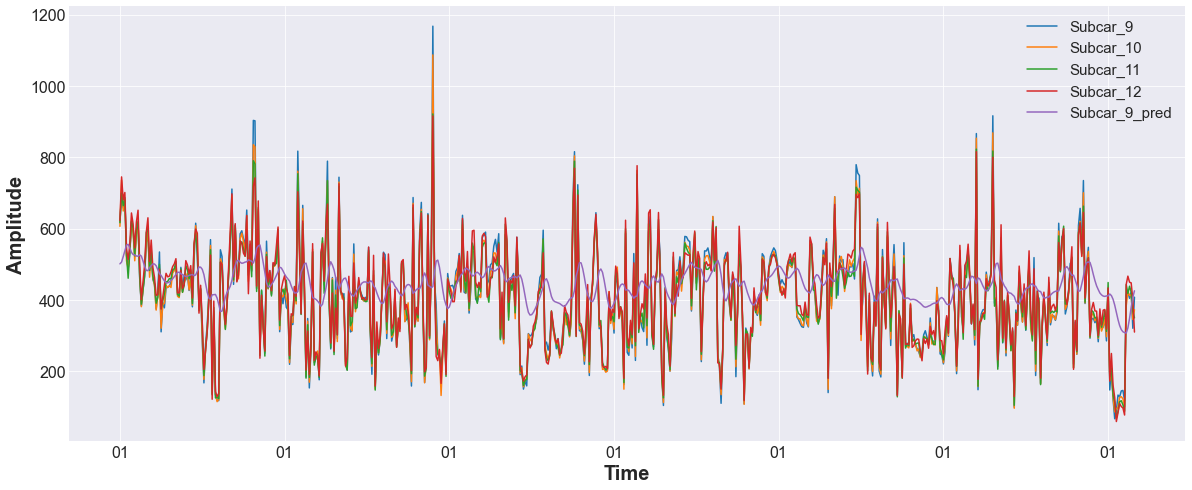

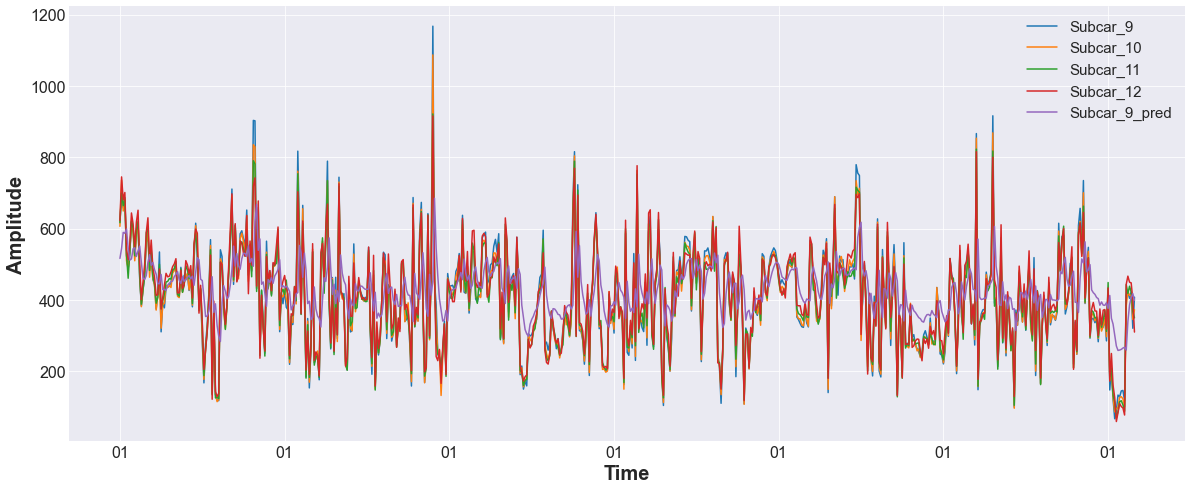

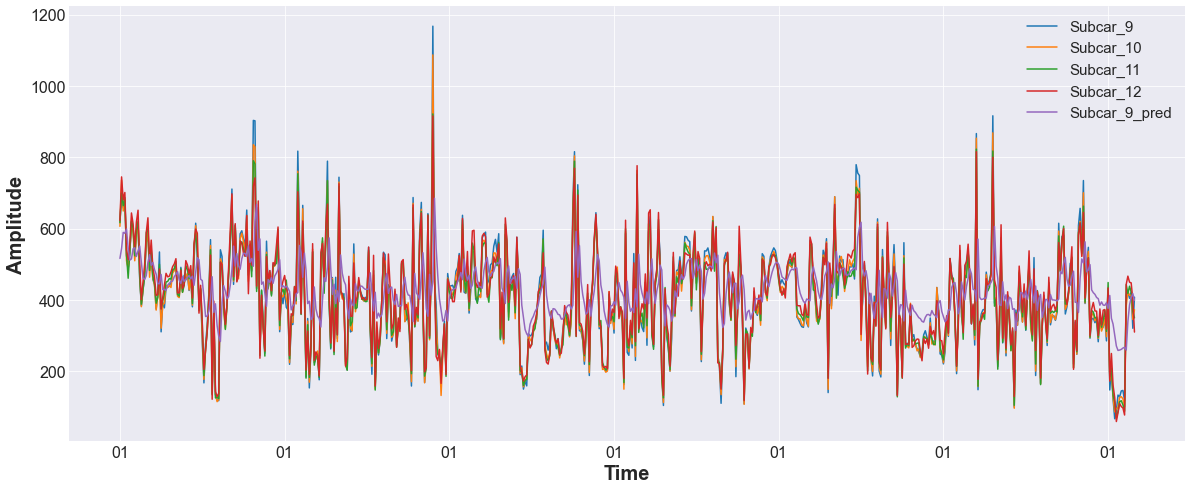

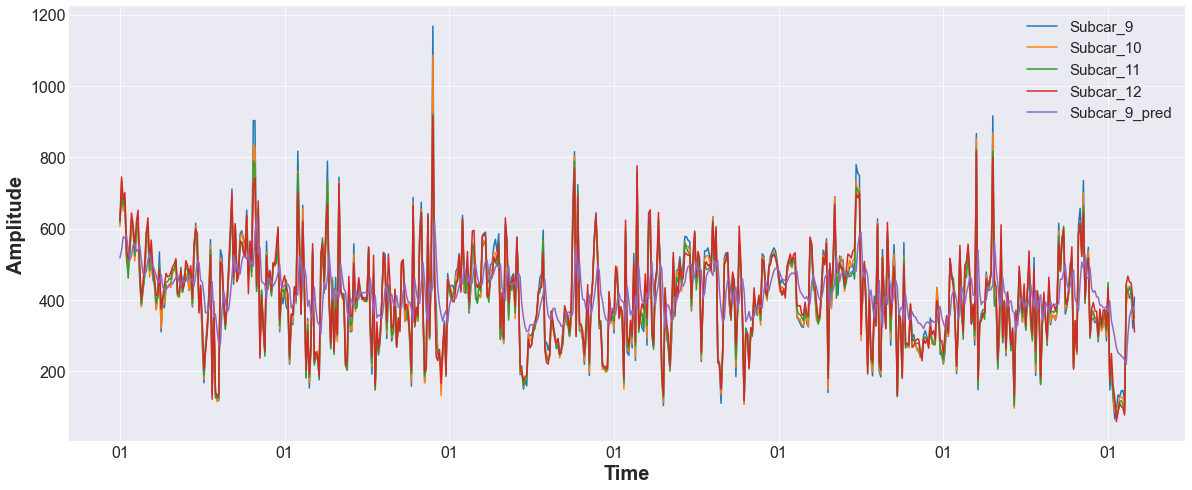

In [63]:
df_final_lstm[['Subcar_9', 'Subcar_9_pred']]
df_final_lstm.index = date_time[:617]
_ = df_final_lstm.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/lstm_curve.png', dpi=120)

df_final_gru[['Subcar_9', 'Subcar_9_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/bilstm_curve.png', dpi=120)

df_final_conv[['Subcar_9', 'Subcar_9_pred']]
df_final_conv.index = date_time[:617]
_ = df_final_conv.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/conv_curve.png', dpi=120)


df_final_gr[['Subcar_9', 'Subcar_9_pred']]
df_final_gr.index = date_time[:617]
_ = df_final_gr.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/gru_curve.png', dpi=120)


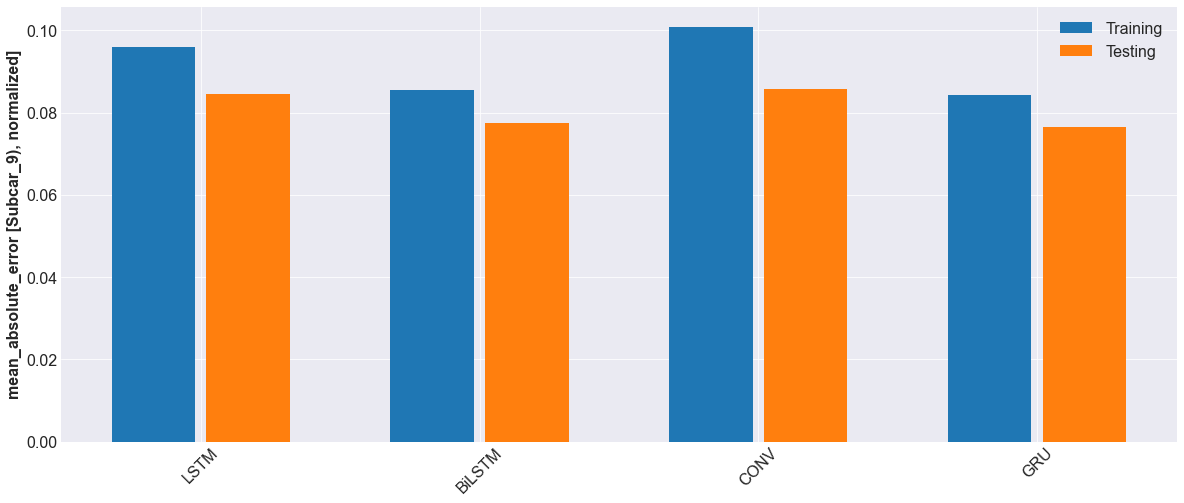

In [64]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Subcar_9), normalized]',
           fontsize=16, fontweight='bold', horizontalalignment='center')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Testing')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45, fontsize=16)
plt.yticks(fontsize=16)
_ = plt.legend(fontsize=16)
# plt.savefig('../images/bar_graph.png', dpi=120)


In [65]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.0846
BiLSTM      : 0.0776
CONV        : 0.0856
GRU         : 0.0764


In [66]:
for name, value in val_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.0959
BiLSTM      : 0.0856
CONV        : 0.1007
GRU         : 0.0842


No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

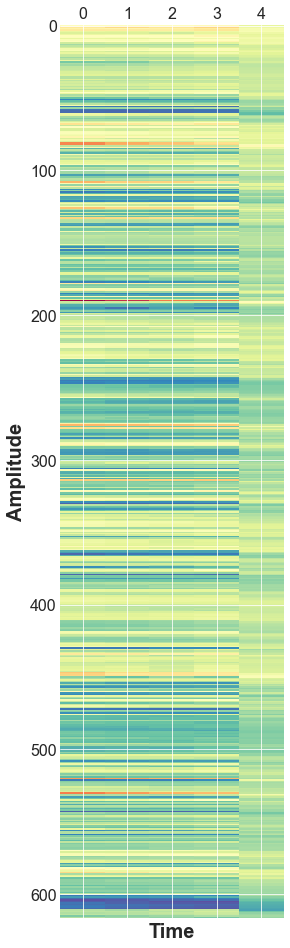

In [67]:
plt.matshow(df_final_gr, interpolation='nearest',
            aspect='auto', cmap=plt.cm.Spectral_r)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
plt.show


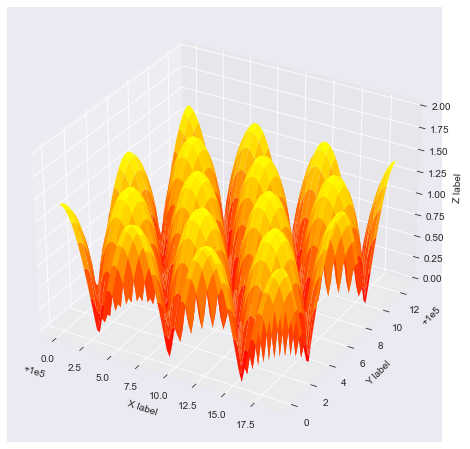

In [68]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

df_pred_gr, df_final_gr = np.mgrid[0:6*np.pi:0.25, 0:4*np.pi:0.25]
Z = np.sqrt(np.abs(np.cos(df_pred_gr) + np.cos(df_final_gr)))

ax.plot_surface(df_pred_gr + 1e5, df_final_gr + 1e5, Z,
                cmap='autumn', cstride=2, rstride=2)

ax.set_xlabel("X label")
ax.set_ylabel("Y label")
ax.set_zlabel("Z label")
ax.set_zlim(0, 2)

plt.show()


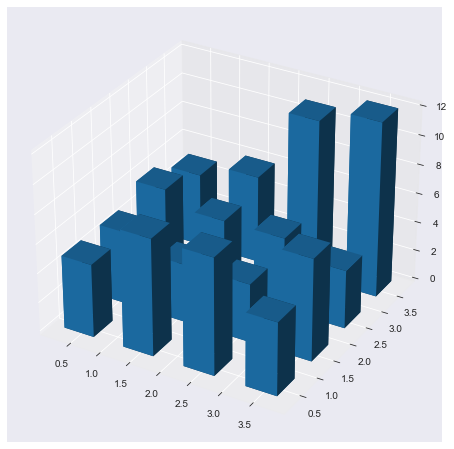

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
df_pred_gr, df_final_gr = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(df_pred_gr, df_final_gr, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()


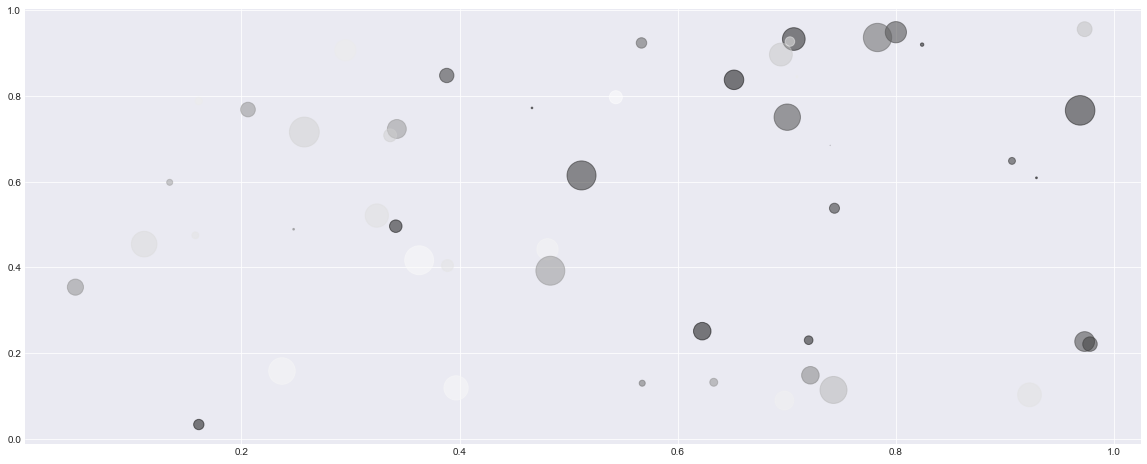

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


N = 50
df_pred_gr = np.random.rand(N)
df_final_gr = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(df_pred_gr, df_final_gr, s=area, c=colors, alpha=0.5)
plt.show()


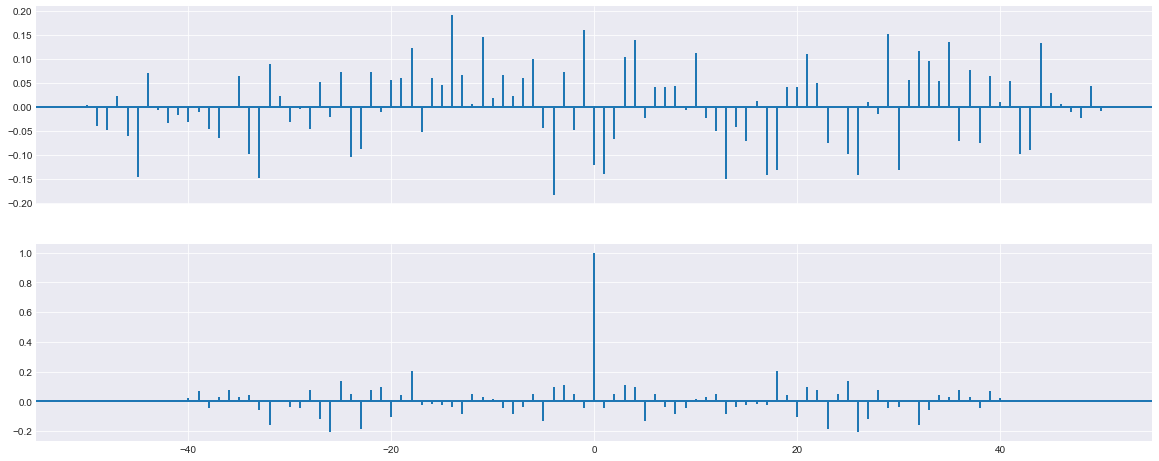

In [71]:

# Fixing random state for reproducibility
np.random.seed(19680801)


df_pred_gr, df_final_gr = np.random.randn(2, 100)
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(df_pred_gr, df_final_gr, usevlines=True, maxlags=50, normed=True, lw=2)
ax1.grid(True)

ax2.acorr(df_pred_gr, usevlines=True, normed=True, maxlags=40, lw=2)
ax2.grid(True)

plt.show()


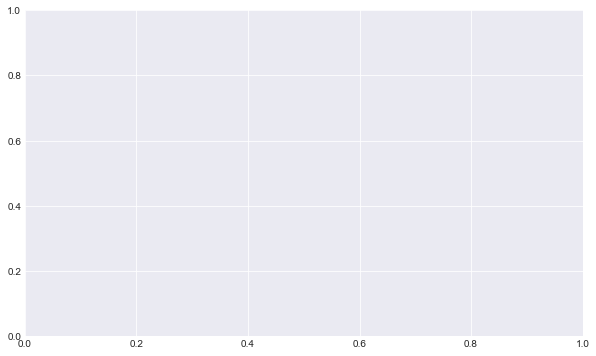

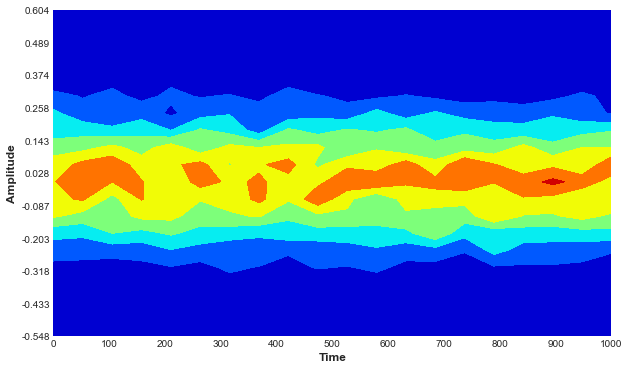

In [72]:
series_len = 1000
n_series = 10

fig, ax = plt.subplots(figsize=(10, 6))
np.random.seed(1)
df_final_gr = np.random.normal(0, 0.15, series_len * n_series)
df_pred_gr = np.tile(np.arange(0, series_len, 1), n_series)

heatmap, xs, ys = np.histogram2d(df_pred_gr, df_final_gr, bins=20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.contourf(heatmap.T, cmap='jet')

# the actual x-axis and y-axis are from 0 to 19
# we want to put 11 ticks on the axis
ax.set_xticks(np.linspace(0, 19, 11))
ax.set_xticklabels(range(0, 1001, 100))

ax.set_yticks(np.linspace(0, 19, 11))
ax.set_yticklabels(['{:.3f}'.format(y) for y in ys[::2]])
plt.ylabel("Amplitude", fontsize=12, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=12, fontweight='bold',
           horizontalalignment='center')

plt.show()


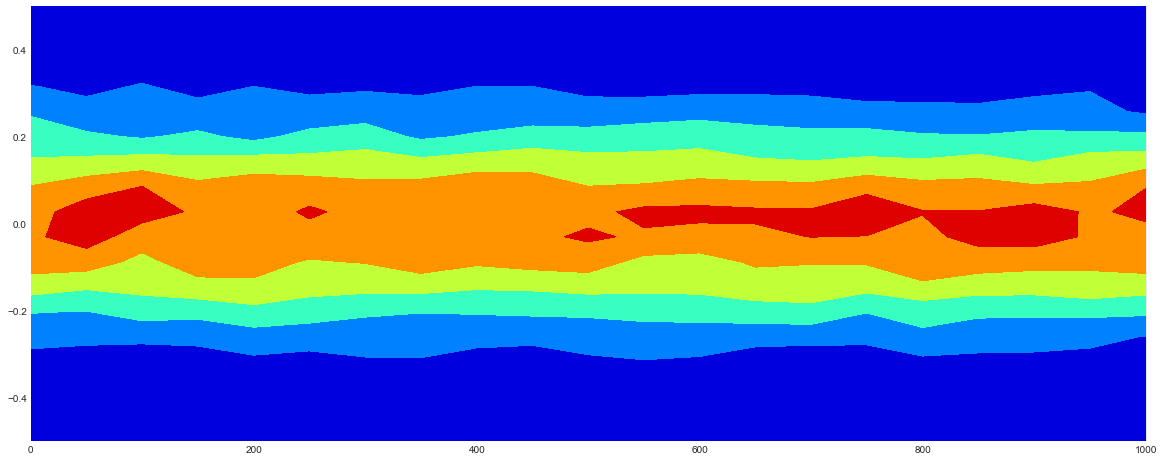

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform

series_len = 1000
n_series = 10
bins = 20
y = np.random.normal(0, 0.15, series_len * n_series)
x = np.tile(np.arange(0, series_len, 1), n_series)

heatmap, xlabels, ylabels = np.histogram2d(
    df_pred_gr, df_final_gr, bins=bins)
heatmap = skimage.transform.resize(
    heatmap, output_shape=(bins+1, bins+1), mode="symmetric")

plt.contourf(xlabels, ylabels, heatmap.T, cmap='jet')
plt.xlim(0, 1000)
plt.ylim(-0.5, 0.5)
plt.show()


In [74]:

def heatmap(csi_df):

    df = csi_df

    packet_idx = [i for i in range(1, len(df) + 1)]

    x_list = []
    for idx in packet_idx:
        x_list.append(idx)

    y_list = []
    for col in df.columns:
        y_list.append(col)

    plt.pcolor(x_list, y_list, df.transpose(), cmap='jet', shading='auto')
    cbar = plt.colorbar()
    cbar.set_label('Amplitude (dBm)')

   #xtic = np.arange(0, x_list[-1] + 1, 100)
    #xtic[0] = 1
    #ytic = np.arange(0, 52, 13)

    #plt.xticks(xtic)
    #plt.yticks(ytic, [y_list[idx] for idx in [0, int(len(y_list)/4), int(len(y_list)/4*2), int(len(y_list)/4*3)]])
    plt.xlabel('Packet Index')
    plt.ylabel('Subcarrier Index')

    plt.show()


data_path = "../output"
data_fname = "zero4_outputs.csv"

data_path = os.path.join(data_path, data_fname)

# Read csi.csv
df = pd.read_csv(data_path)


In [75]:
# Choose subcarriers
# df = df[['Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12', ]]

# heatmap(df)
